# 1. Load Packages

In [37]:
import sys
import os
import random
import numpy as np
import datetime
import shutil
import logging

import torch
import torch.nn as nn
from torch import autograd
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

import optuna
from optuna.trial import TrialState
import mlflow

# data distributed parallelization DDP
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from GNet256_Greyscale import OptGenGreyscale256
from DNet256 import OptDis256
from utils import normalizeRGB
from utils import weights_init
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Set Params

In [ ]:
dataroot = "../../png/train" # Root directory for train dataset
datarootTest = "../../png/test" # Root directory for dataset
cadastralRoot = '../../cadastralExportRGB' # Root directory for cadastral images
cadastralRootGreyscale = '../../cadastralExport' # Root directory for cadastral images in greyscale
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 256 # Spatial size of training images. All images will be resized to this
nc = 1 # Number of channels in the training images. For color images this is 3
nz = 2**4*4*4 # Size of z latent vector (i.e. size of generator input)
# ngf = 64 # Size of feature maps in generator
# ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/07_WGAN.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 3. Dataloader

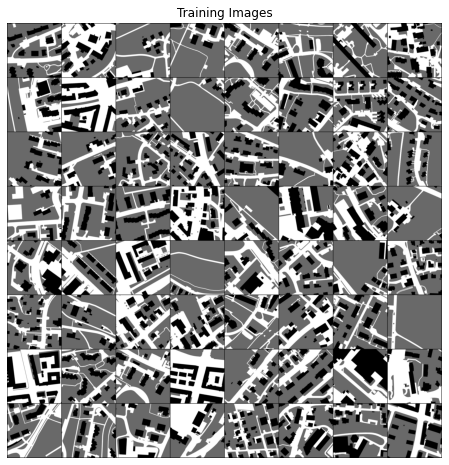

In [7]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRootGreyscale + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRootGreyscale + '/.ipynb_checkpoints')

Cad_dataset_greyscale = dset.ImageFolder(root=cadastralRootGreyscale,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 2),
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Grayscale(num_output_channels=1)
                           ]))
# Create the dataloader
Cad_dataloader_greyscale = torch.utils.data.DataLoader(Cad_dataset_greyscale, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_gs_real_batch = next(iter(Cad_dataloader_greyscale))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_gs_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [8]:
Cad_dataset_greyscale

Dataset ImageFolder
    Number of datapoints: 2569
    Root location: ../../cadastralExport
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(512, 512))
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Grayscale(num_output_channels=1)
           )

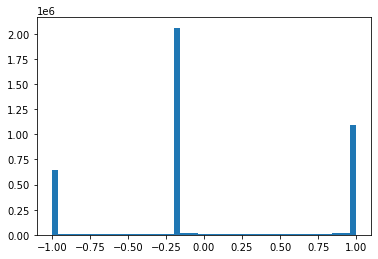

In [9]:
plt.hist(Cad_gs_real_batch[0].flatten().tolist(), bins = 50);

# 4. Generator

In [10]:
netG = OptGenGreyscale256(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4).to(device)
netG.apply(weights_init)
print(netG)

OptGenGreyscale256(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (4): DropOut_2): Dropout2d(p=0.4, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 32, kernel_size=(9, 9), stride=(3, 3), bias=False)
    (8): DropOut_3): Dropout2d(p=0.4, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(32, 1, kernel_size=(9, 9), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)


In [11]:
%%time
z = torch.randn(batch_size, nz, 1, 1, device=device)
pred = netG.forward(z)

CPU times: user 988 ms, sys: 551 ms, total: 1.54 s
Wall time: 1.54 s


In [12]:
pred.size()

torch.Size([64, 1, 256, 256])

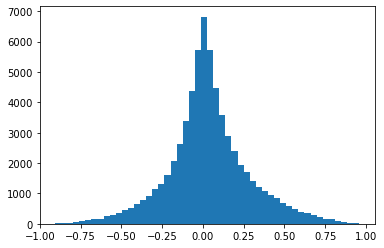

In [13]:
plt.hist(pred[0].flatten().tolist(), bins = 50);

# 5. Discriminator

In [28]:
netD = OptDis256(ngpu=ngpu, num_conv_layers=3, in_channels=1).to(device)
netD.apply(weights_init)
print(netD)

OptDis256(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(7, 7), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(3, 3), bias=False)
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Fully Connected 1): Linear(in_features=4096, out_features=512, bias=True)
    (ReLU): ReLU(inplace=True)
    (Fully Connected 2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [29]:
%%time
xr = Cad_gs_real_batch[0].to(device)
pred = netD(xr).view(-1)

CPU times: user 6.78 ms, sys: 0 ns, total: 6.78 ms
Wall time: 6.19 ms


In [30]:
pred.size()

torch.Size([64])

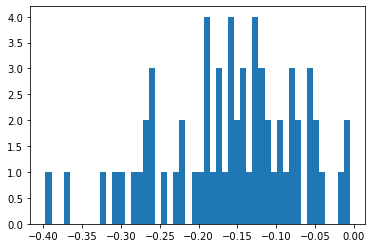

In [31]:
plt.hist(pred.flatten().tolist(), bins = 50);

# 6. Training

In [32]:
# logging
loggerGreyscale = logging.getLogger('loggerGreyscale')
loggerGreyscale.setLevel(logging.DEBUG)
# formatter = loggerGreyscale.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/WGAN_CadastralGreyscale256.log')
file_handler.setFormatter(formatter)
loggerGreyscale.addHandler(file_handler)

In [38]:
%%time

fixed_noise = torch.rand((64*2**4*4*4)).to(device)
torch.manual_seed(23)
np.random.seed(23)

netG = OptGenGreyscale256(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4)
netD = OptDis256(ngpu=ngpu, num_conv_layers=3, in_channels=1).to(device)

# If more devices are available
if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

netG.to(device)
netD.to(device)

netG.apply(weights_init)
netD.apply(weights_init)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

imgs= trainModel(netG, netD, device, Cad_dataloader_greyscale, 
                 optimizerG, optimizerD, epochs=10, nz=nz, fixed_noise=fixed_noise, 
                 folder='../', logger=loggerGreyscale)

Epoch: 0/10 | D Learn: True | D Loss: -27.156| ErrDReal: -145.433 | ErrDFake: 118.1217 | GradPenality: 0.1553 | G Loss: -11.0104
CPU times: user 34.7 s, sys: 4.23 s, total: 38.9 s
Wall time: 7min 20s


In [36]:
netG.eval()

OptGenGreyscale256(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (4): DropOut_2): Dropout2d(p=0.4, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 32, kernel_size=(9, 9), stride=(3, 3), bias=False)
    (8): DropOut_3): Dropout2d(p=0.4, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(32, 1, kernel_size=(9, 9), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)